# Importing the required modules

In [2]:
# Modules for data manipulation and visualisation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Module for handling json documents.
import json

# Modules for the NER and its customisation.
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example
from pathlib import Path
from spacy import displacy

# Module for matching regular expressions.
import re

# Module for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Module for random sampling for training data.
import random

# Mathematical working

In [9]:
nlp = spacy.load("en_core_web_sm")
question = nlp("Is there a train connection between Ahmedabad Junction and Mumbai Central?")

In [19]:
print("Norm of the vector",norm(question.vector))

Norm of the vector 2.9139583


In [10]:
data

{'TrainCheck': ['Is X the train number of Y?', 'Does X have train number Y?'],
 'RouteCheck': ['Are X and Y connected by rail?',
  'Is there a train connecting X and Y?',
  'X and Y have a rail connection?']}

In [28]:
for intent in data:
    r = []
    for qs in data[intent]:
        y = nlp(qs)
        
        print("Similiarity = ",x.similarity(y))
        print("Norm of the vector", norm(x.vector),norm(y.vector),norm(x.vector)*norm(y.vector),np.dot(x.vector,y.vector)/(norm(x.vector)*norm(y.vector)))
        print("Dot product ",np.dot(x.vector,y.vector))
        r.append(np.dot(x.vector,y.vector)/(norm(x.vector)*norm(y.vector)))
    print(intent,sum(r),sum(r)/len(r))

Similiarity =  0.6798174503790722
Norm of the vector 2.9979875 3.266782 9.793772 0.67981744
Dot product  6.657977
Similiarity =  0.46066697900465015
Norm of the vector 2.9979875 3.6204815 10.854158 0.460667
Dot product  5.0001526
TrainCheck 1.1404844522476196 0.5702422261238098
Similiarity =  0.6939928497733847
Norm of the vector 2.9979875 3.1317286 9.388884 0.69399285
Dot product  6.515818
Similiarity =  0.737622320658129
Norm of the vector 2.9979875 3.1211364 9.357128 0.7376223
Dot product  6.9020267
Similiarity =  0.5573778379995812
Norm of the vector 2.9979875 2.9339004 8.795796 0.5573779
Dot product  4.902582
RouteCheck 1.9889930486679077 0.6629976828893026


In [4]:
from numpy.linalg import norm

In [18]:
np.dot(x.vector,y.vector)/(norm(x.vector)*norm(y.vector))

0.6798175

In [11]:
x.similarity(y)

0.6798174990668667

# Question Input

In [91]:
qs = input()

# Intent Classification

$$Cosine \text{ Similiarity} = \frac{a.b}{ \| a\|.\|b\|} $$

<p>Overall Similiarity for TrainCheck intent is calculated by the mean of the cosine similiarity of each question under that intent.</p>

$$\text{Overall Similiarity for Train Check} = \frac{1}{N_{TrainCheck}} \sum_{k=0}^{N_{TrainCheck}} \frac{a. b_{k} }{ \| a\|.\|b_{k}\|}$$

<p>Overall Similiarity for RouteCheck intent is calculated by the mean of the cosine similiarity of each question under that intent.</p>

$$\text{Overall Similiarity for Route Check} = \frac{1}{N_{RouteCheck}} \sum_{k=0}^{N_{RouteCheck}} \frac{a. b_{k} }{ \| a\|.\|b_{k}\|}$$

<p>The intent with the maximum overall similiarity is assigned to the question.</p>

In [5]:
file = open(r"..\data\intent_classification_data.json")
data = json.load(file)

In [6]:
data

{'TrainCheck': ['Is X the train number of Y?', 'Does X have train number Y?'],
 'RouteCheck': ['Are X and Y connected by rail?',
  'Is there a train connecting X and Y?',
  'X and Y have a rail connection?']}

In [94]:
intent_similiarity = dict()

In [95]:
def question_similiarity(sentence,question):
    nlp = spacy.load("en_core_web_sm")
    sent = nlp(sentence)
    q = nlp(question)
    return sent.similarity(q)

In [96]:
for i in data:
    intent_similiarity[i] = np.mean(list(map(question_similiarity,data[i],[qs]*len(data[i]))))
print(intent_similiarity)

{'TrainCheck': 0.708569796852156, 'RouteCheck': 0.466522582615974}


# Entity Recognition

## Preparing training data

<p>The entities used for this use-case:</p>
<table>
    <tr>
        <th>Entity Type</th>
        <th>Its Meaning</th>
        <th>Used for</th>
    </tr>
    <tr>
        <td>CARDINAL</td>
        <td>Numerical Values that are not dates, 
            times, percent, money or quantity</td>
        <td>Train Number</td>
    </tr>
    <tr>
        <td>GPE</td>
        <td>Geo-Political Entity</td>
        <td>Stations</td>
    </tr>
    <tr>
        <td>FAC</td>
        <td>Facilites</td>
        <td>Train Name</td>
    </tr>
</table>

These entities labels were fine-tuned for the respective labels with their respective use case using Transfer Learning.

### Reading the dataset

In [ ]:
trains = pd.read_csv("..\data\All_Indian_Trains.csv")

In [ ]:
trains.head()

,Unnamed: 0,Train no.,Train name,Starts,Ends
0,0,12723,Andhra Pradesh Express,Hyderabad Decan,New Delhi
1,1,22416,Andhra Pradesh Express,New Delhi,Vishakapatnam
2,2,12724,Andhra Pradesh Express,New Delhi,Hyderabad Decan
3,3,12707,Andhra Pradesh Sampark Kranti,Tirupati,H Nizamuddin
4,4,15909,Abadh Assam Express,New Tinsukia Junction,Darbhanga Junction


In [ ]:
trains = trains.drop(["Unnamed: 0"],axis=1)

In [ ]:
trains.head()

,Train no.,Train name,Starts,Ends
0,12723,Andhra Pradesh Express,Hyderabad Decan,New Delhi
1,22416,Andhra Pradesh Express,New Delhi,Vishakapatnam
2,12724,Andhra Pradesh Express,New Delhi,Hyderabad Decan
3,12707,Andhra Pradesh Sampark Kranti,Tirupati,H Nizamuddin
4,15909,Abadh Assam Express,New Tinsukia Junction,Darbhanga Junction


### Seggragating different forms of questions

In [ ]:
num2name = data["TrainCheck"][0]
name2number = data["TrainCheck"][1]
route_check = data["RouteCheck"]

### All the available unique entities in the dataset

In [ ]:
all_train_nos = list(set(trains["Train no."]))
all_train_names = list(set(trains["Train name"]))
all_stations = list(set(list(trains["Starts"])+list(trains["Ends"])))

### Data Augmentation

In [ ]:
training_data = []

#### Randomly sampling 20 entries of train numbers and names

In [ ]:
train_nos_sampled = random.sample(all_train_nos,20)

In [ ]:
train_names_sampled = random.sample(all_train_names,20)

#### Creating training data for TrainCheck

In [ ]:
for i in list(zip(train_nos_sampled,train_names_sampled)):
    prepared_str = num2name.replace("X",str(i[0])).replace("Y",i[1])
    training_data.append((prepared_str,{"entities":[getFirstMatch(str(i[0]),prepared_str,"CARDINAL"),getFirstMatch(i[1],prepared_str,"FAC")]}))

In [ ]:
for i in list(zip(train_nos_sampled,train_names_sampled)):
    prepared_str = name2number.replace("Y",str(i[0])).replace("X",i[1])
    training_data.append((prepared_str,{"entities":[getFirstMatch(str(i[0]),prepared_str,"CARDINAL"),getFirstMatch(i[1],prepared_str,"FAC")]}))

#### Creating training data for RouteCheck

In [ ]:
for i in range(10):
    for qs in route_check:
        station1 = random.choice(all_stations)
        station2 = random.choice(all_stations)
        prepared_str = qs.replace("X",station1).replace("Y",station2)
        training_data.append((prepared_str,{"entities":[getFirstMatch(station1,prepared_str,"GPE"),getFirstMatch(station2,prepared_str,"GPE")]}))

#### Storing the generated training data in a json document

In [ ]:
with open(r'..\data\ner_training_data.json', 'w') as f:
    json.dump({"training_data":training_data}, f)

## Fine tuning the NER pipeline

### Loading the training data

In [3]:
training_data = json.load(open(r"..\data\ner_training_data.json","r"))

In [4]:
training_data = training_data["training_data"]

In [5]:
len(training_data)

60

In [ ]:
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")

In [ ]:
for _, annotations in training_data:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [ ]:
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

Here, we are customising the default NER model of spacy to fine tune it for this particular use-case.
- Disabling unaffected pipes.
- Random Shuffling of the training data.
- Using mini-batch learning to training the neural network.
- Using the label data and updating the nlp pipeline with a particular example.

In [ ]:
l = []
with nlp.disable_pipes(*unaffected_pipes):
  for iteration in range(60):
    random.shuffle(training_data)
    losses = {}
    batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
         doc = nlp.make_doc(text)
         example = Example.from_dict(doc, annotations)
         nlp.update(
                    [example],
                    drop=0.5,
                    losses=losses,
                )
        l.append(losses["ner"])

### Backpropagation loss of Customisation of NER

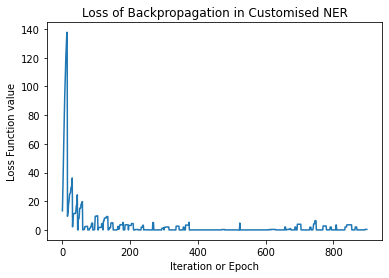

In [ ]:
plt.plot(list(range(len(l))),l)
plt.xlabel("Iteration or Epoch")
plt.ylabel("Loss Function value")
plt.title("Loss of Backpropagation in Customised NER")
plt.show()

### Mini-Batch Learning

In [6]:
batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))

In [7]:
for i in batches:
    print(len(i))

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [2]:
size=compounding(4.0, 32.0, 1.001)

In [3]:
batch_sizes = []
while True:
   next_size = next(size)
   if next_size == 32.0:
      break
   else:
      batch_sizes.append(next_size)

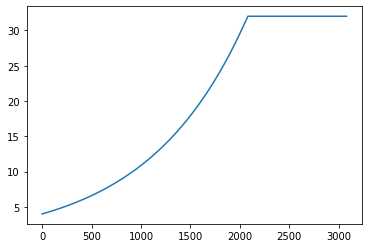

In [4]:
plt.plot(batch_sizes+[32]*(10**3))

### Saving the NER model

In [ ]:
nlp.to_disk("../models/railways_ner")

### Sample Outputs of NER model

In [3]:
nlp = spacy.load("../models/railways_ner")
old_nlp = spacy.load("en_core_web_sm")

In [4]:
x = nlp("Is there a train connection between Ahmedabad Junction and Mumbai Central?")
y = old_nlp("Is there a train connection between Ahmedabad Junction and Mumbai Central?")

In [5]:
 displacy.render(x,"ent")

In [6]:
 displacy.render(y,"ent")


In [25]:
questions=[
    "Is there any train connectivity between New Delhi and Kolkata?",
    "Is 12345 the train number of XYZ Express?",
    "Does Bdts Jp Superfast Express have train number 22933?",
    "Are Bandra Terminus and H Nizamuddin connected by rail?",
    "The Beas Sre Special with train number 4918 connects Beas and Saharanpur",
    "Are there any trains from Kanpur Central to Durg?",
    "Are any trains scheduled between Kolkata and Mumbai CST?",
    "Is Jodhpur Junction connected with Valsad by rail?"
]

#### Output using the default NER

In [26]:
for i in questions:
 x = old_nlp(i)
 displacy.render(x,"ent")

#### Output using customised NER

In [27]:
for i in questions:
 x = nlp(i)
 displacy.render(x,"ent")

### Getting the output in required format

In [72]:
entities = nlp(qs).ents
entities_with_labels = []

In [73]:
for i in entities:
    entities_with_labels.append((i.label_,i.text))

In [74]:
entities_with_labels

[('CARDINAL', '9427'), ('FAC', 'Adi Ald Special')]

# Question Answering

### Column-Intent Mapping

In [97]:
column_intent_mapping = {
    "TrainCheck":["Train no.","Train name"],
    "RouteCheck":["Starts","Ends"]
}

### Intent Extraction

In [98]:
intent_similiarity

{'TrainCheck': 0.708569796852156, 'RouteCheck': 0.466522582615974}

In [99]:
intent = max(zip(intent_similiarity.values(), intent_similiarity.keys()))[1]
print(intent)

TrainCheck


In [100]:
relevant_columns = column_intent_mapping[intent]

In [101]:
trains = pd.read_csv("..\data\All_Indian_Trains.csv")

In [102]:
search_space = trains[relevant_columns]

In [103]:
dict(entities_with_labels)

{'CARDINAL': '9427', 'FAC': 'Adi Ald Special'}

In [104]:
if intent == "RouteCheck":
   search_results = search_space.loc[(search_space['Starts'] == entities_with_labels[0][1]) & (search_space['Ends'] == entities_with_labels[1][1])]
else:
   entities_with_labels = dict(entities_with_labels)
   search_results = search_space.loc[(search_space['Train no.'] == int(entities_with_labels["CARDINAL"])) & (search_space['Train name'] == entities_with_labels["FAC"])]

In [105]:
response = "No"
if len(search_results) > 0:
    response = "Yes"

In [106]:
response

'Yes'